# On fait un jupyter notebook pour faire des analyses de données en R 

In [1]:
# Installer le package IRKernel si ce n'est pas déjà fait
install.packages("IRkernel")
# Enregistrer le kernel R pour Jupyter
IRkernel::installspec(user = FALSE)



The downloaded binary packages are in
	/var/folders/fk/0bsjkdcj1tx8lwj96knp7y_m0000gn/T//Rtmpnru0C3/downloaded_packages


In [2]:
#library
library(cardx)
library(dplyr)
library(openxlsx)
library(tidyverse)
library(gtsummary)
library(ClaudeR)
library(magrittr)
library(ggplot2)
library(lubridate)
library(ggpubr)
library(survival)
library(survminer)
library(summarytools)
library(MatchIt)
library(optmatch)
library(scales)
library(officer)
library(flextable)
library(gt)
library(mice)
library(googlesheets4)
library(cards)
library(stringr)
library(purrr)
library(RItools)
library(epiR)
library(tableone)
library(cobalt)
library(broom)
library(gridExtra)
library(forcats)
library(dlstats)
library(pkgsearch)
library(pROC)
library(stats)
library(parameters)
library(broom.helpers)
library(knitr)
library(forestplot)
library(kableExtra)
library(rsconnect)
library(shiny)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.1     ✔ readr     2.1.5
✔ ggplot2   4.0.0     ✔ stringr   1.5.2
✔ lubridate 1.9.4     ✔ tibble    3.3.0
✔ purrr     1.1.0     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma



Attaching package: ‘s

In [3]:
##-------IMPORT DES DONNÉES + NETTOYAGE-----
rm(list=ls())

#ggsheets deauth
gs4_deauth()

import_and_clean_logbook_data <- function() {
  
  # Configuration des URLs Google Sheets
  sheets_urls <- list(
    Cochin = "https://docs.google.com/spreadsheets/d/1ZWEY6L2vRm6VHkOw_ytbFpaeiv6h_FRQOJCVl7c1t4k/edit?usp=sharing",
    Paul_Brousse = "https://docs.google.com/spreadsheets/d/176ze81vIL38_HdT3XVThSyLbBXr4ZLCYkdjPJxAh1HI/edit?usp=sharing",
    St_Louis = "https://docs.google.com/spreadsheets/d/1w52ZALvJ2uOKgn1bcaILuQ6j0A2W1_oFzmf0hxeSUNE/edit?usp=sharing",
    HEGP = "https://docs.google.com/spreadsheets/d/1gXd9f2ZID3VL5oTTQ0j_JxtYjk9fb9C2s1LmTBhvTJg/edit?usp=sharing",
    PSL = "https://docs.google.com/spreadsheets/d/1CAfPAdzhKSbARkMZagJE5gmLMwAJn5WN4N3dJgijedE/edit?gid=0#gid=0",
    Cochin2 = "https://docs.google.com/spreadsheets/d/1bd7WkoZrHbfW3AhFfZgxgzCjJ7cv0tDgHUZ7BIahjoE/edit?gid=0#gid=0",
    Avicenne = "https://docs.google.com/spreadsheets/d/1XTiRmVf7B_bVcfF53AwKRXC8WrEiKe0O-UUcmfrVnws/edit?gid=0#gid=0"
  )
  
  # Colonnes standardisées
  colonnes_standard <- c(
    "DATE", "NOM_interne", "INTERVENTION", "Garde_Programme", "Ambu", 
    "OPERATEUR", "OPERATEUR_2", "RANG_BOSS", "RANG_INTERNE", "Geste", 
    "QUEL_GESTE_0No_1paroi_2dissection_3anastomose_4Tout", "Geste_whole_text", 
    "Geste_a_l_aise", "Si_pas_de_geste_RESSENTI", "AMBIANCE", "PEDAGOGIE", 
    "SELF_ESTIME_SORTIE", "Hôpital"
  )
  
  # Fonction helper pour lecture et harmonisation d'une sheet
  read_and_clean_sheet <- function(sheet_url, hospital_name) {
    # Lecture et ajout de l'hôpital
    data <- read_sheet(sheet_url) %>%
      mutate(Hôpital = hospital_name) %>%
      rename_with(~ str_replace_all(., " ", "_"))
    
    # Renommage conditionnel des colonnes
    rename_mapping <- c(
      "Geste?" = "Geste",
      "Garde_Programme" = "Garde_Programme",
      "Ambu" = "Ambu",
      "OPERATEUR" = "OPERATEUR",
      "OPERATEUR_2" = "OPERATEUR_2",
      "AMBIANCE" = "AMBIANCE",
      "PEDAGOGIE" = "PEDAGOGIE",
      "SELF_ESTIME_SORTIE" = "SELF_ESTIME_SORTIE",
      "Si_pas_de_geste_RESSENTI" = "Si_pas_de_geste_RESSENTI",
      "Geste_a_l_aise" = "Geste_a_l_aise"
    )
    
    for (old_name in names(rename_mapping)) {
      if (old_name %in% colnames(data)) {
        data <- data %>% rename(!!sym(rename_mapping[old_name]) := !!sym(old_name))
      }
    }
    
    # Suppression colonne spécifique et ajout colonnes manquantes
    data <- data %>%
      select(-any_of("IPP patient.e"))
    
    # Ajouter colonnes manquantes
    missing_cols <- setdiff(colonnes_standard, colnames(data))
    for (col in missing_cols) {
      data[[col]] <- NA_character_
    }
    
    # Réorganiser et convertir
    data <- data %>%
      select(all_of(colonnes_standard)) %>%
      mutate(across(everything(), as.character))
    
    return(data)
  }
  
  # Import et fusion des données de tous les hôpitaux
  df <- map2_dfr(sheets_urls, names(sheets_urls), read_and_clean_sheet)
  
  # Nettoyage et harmonisation (ordre exact de l'ancien script)
  df <- df %>%
    # 1. Nettoyage SELF_ESTIME_SORTIE seulement
    mutate(SELF_ESTIME_SORTIE = str_trim(SELF_ESTIME_SORTIE)) %>%
    
    # 2. Harmonisation PEDAGOGIE
    mutate(PEDAGOGIE = case_when(
      PEDAGOGIE == "1" ~ "1-rien",
      PEDAGOGIE == "2" ~ "2-quasi rien",
      PEDAGOGIE == "3" ~ "3-ok",
      PEDAGOGIE == "4" ~ "4-bien",
      PEDAGOGIE == "5" ~ "5-incroyable!!",
      TRUE ~ PEDAGOGIE
    )) %>%
    mutate(PEDAGOGIE = factor(PEDAGOGIE, 
                              levels = c("1-rien", "2-quasi rien", "3-ok", "4-bien", "5-incroyable!!"), 
                              ordered = TRUE)) %>%
    
    # 3. Nettoyage AMBIANCE séparément  
    mutate(AMBIANCE = str_trim(AMBIANCE)) %>%
    
    # 4. Harmonisation AMBIANCE (avec case_when explicite comme l'original)
    mutate(AMBIANCE = case_when(
      AMBIANCE == "1 - je veux partir" ~ "1 - je veux partir",
      AMBIANCE == "2 - c'est ok" ~ "2 - c'est ok",
      AMBIANCE == "3 - on recommence" ~ "3 - on recommence",
      TRUE ~ AMBIANCE
    )) %>%
    mutate(AMBIANCE = factor(AMBIANCE, 
                             levels = c("1 - je veux partir", "2 - c'est ok", "3 - on recommence"), 
                             ordered = TRUE))
  
  # 5. Modifications RANG (style original avec $)
  df$RANG_BOSS <- gsub("Dr Junior", "DJ", df$RANG_BOSS)
  df$RANG_INTERNE <- gsub("^1e aide$", "1er aide", df$RANG_INTERNE)
  
  # 6. Filtrage (style original avec crochets)
  df <- df[!(df$RANG_BOSS == "Interne" | df$RANG_INTERNE == "Spectateur non habillé"), ]
  
  # 7. Modification Garde_Programme (après filtrage)
  df <- df %>%
    mutate(Garde_Programme = case_when(
      Garde_Programme == "Astreinte" ~ "Garde",
      TRUE ~ Garde_Programme
    ))
  
  return(df)
}

#import de tout le df
df <- import_and_clean_logbook_data()

#faire un df uniquement pour Paul Brousse
df_PBR <- df %>%
  filter(Hôpital == "Paul_Brousse")


✔ Reading from Logbook Cochin Hiver 24-25.

✔ Range Feuille1.

✔ Reading from Logbook PBR Hiver 24-25.

✔ Range Feuille1.

✔ Reading from Logbook SLS Hiver 24-25.

✔ Range Feuille1.

✔ Reading from Logbook HEGP.

✔ Range Feuille1.

✔ Reading from Logbook Pitié Eté 24-25.

✔ Range Feuille1.

✔ Reading from Logbook Cochin Ete 25.

✔ Range Feuille1.

✔ Reading from Logbook Avicenne été 24-25.

✔ Range Feuille1.



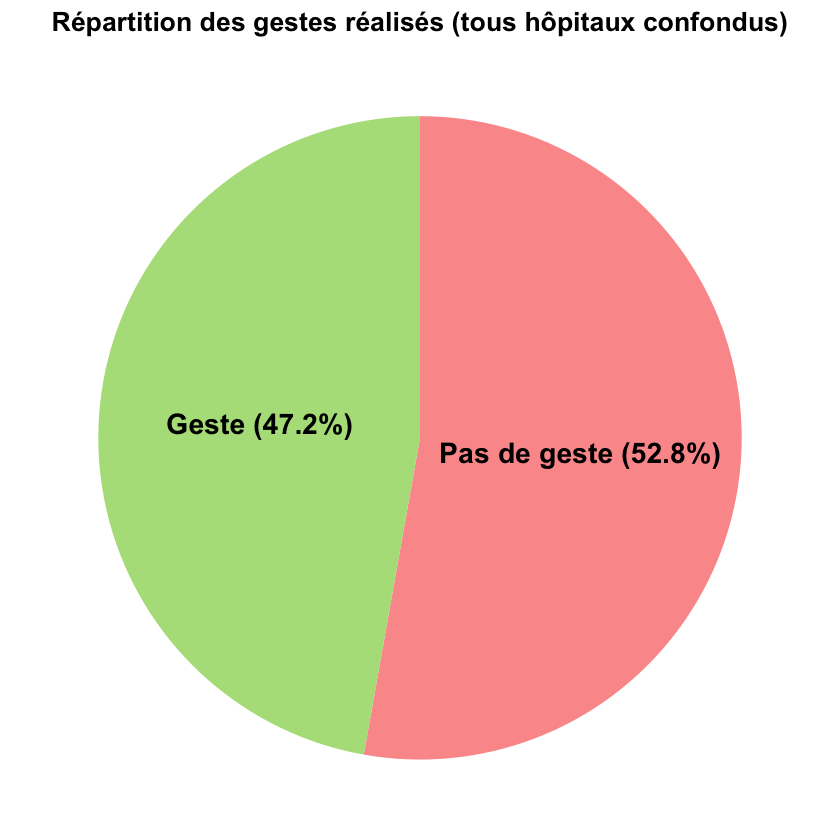

In [8]:
# Calcul des effectifs
df_geste_global <- df %>%
  filter(!is.na(Geste)) %>%
  count(Geste) %>%
  mutate(
    pourcentage = n / sum(n),
    label = paste0(round(100 * pourcentage, 1), "%"),
    # Étiquettes en français
    Geste_francais = case_when(
      Geste == "Yes" ~ "Geste",
      Geste == "No" ~ "Pas de geste",
      TRUE ~ Geste
    ),
    label_complet = paste0(Geste_francais, " (", round(100 * pourcentage, 1), "%)") 
  )

# Diagramme en secteurs (camembert)
camembertgeste <- ggplot(df_geste_global, aes(x = "", y = pourcentage, fill = Geste_francais)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar("y", start = 0) +
  geom_text(aes(label = label_complet), 
            position = position_stack(vjust = 0.5), 
            size = 6, fontface = "bold") +
  scale_fill_manual(values = c("Geste" = "#b2df8a", "Pas de geste" = "#fb9a99")) +
  labs(title = "Répartition des gestes réalisés (tous hôpitaux confondus)") +
  theme_void(base_size = 14) +
  theme(
    legend.position = "none",
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold")
  )

camembertgeste

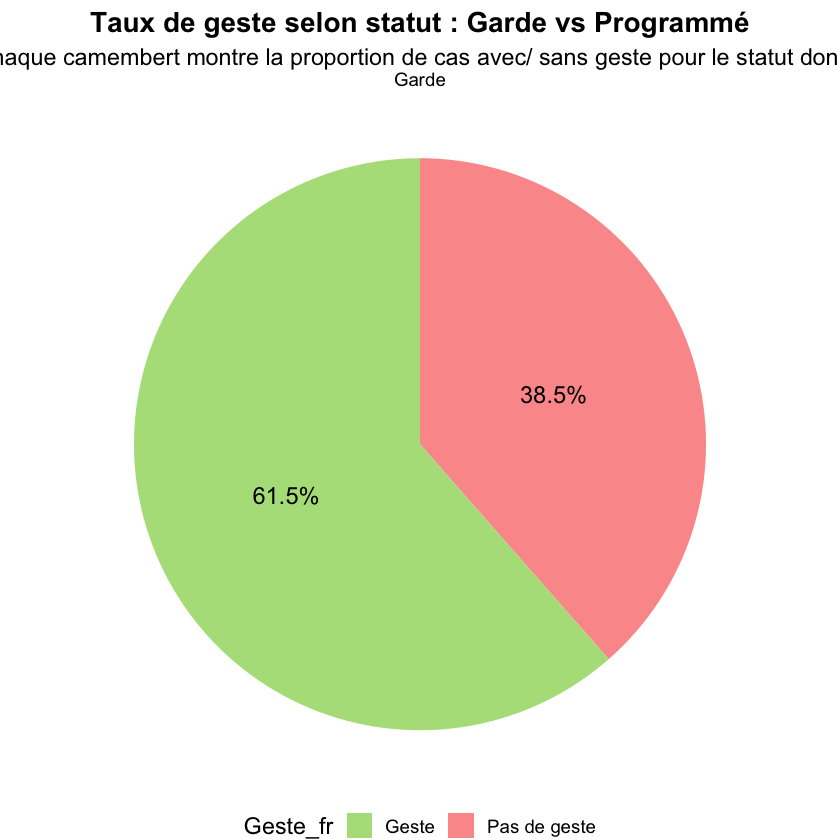

In [13]:
# Calculer le taux de geste pour "Garde" vs "Programme" et afficher deux camemberts (un par statut)
df_garde_geste <- df %>%
    filter(!is.na(Geste), !is.na(Garde_Programme)) %>%
    filter(Garde_Programme %in% c("Garde", "Programme")) %>%
    group_by(Garde_Programme, Geste) %>%
    tally(name = "n") %>%
    group_by(Garde_Programme) %>%
    mutate(
        pourcentage = n / sum(n),
        label = paste0(round(100 * pourcentage, 1), "%"),
        Geste_fr = case_when(
            Geste == "Yes" ~ "Geste",
            Geste == "No"  ~ "Pas de geste",
            TRUE ~ as.character(Geste)
        )
    ) %>%
    ungroup()

camembert_garde <- ggplot(df_garde_geste, aes(x = "", y = pourcentage, fill = Geste_fr)) +
    geom_bar(stat = "identity", width = 1) +
    coord_polar("y", start = 0) +
    geom_text(aes(label = label), position = position_stack(vjust = 0.5), size = 5) +
    facet_wrap(~Garde_Programme) +
    scale_fill_manual(values = c("Geste" = "#b2df8a", "Pas de geste" = "#fb9a99")) +
    labs(title = "Taux de geste selon statut : Garde vs Programmé",
             subtitle = "Chaque camembert montre la proportion de cas avec/ sans geste pour le statut donné") +
    theme_void(base_size = 14) +
    theme(
        legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"),
        plot.subtitle = element_text(hjust = 0.5)
    )

camembert_garde